In [1]:
'''
Text classification example
Supervised learning example using discrete word representations and classification model
'''

'\nText classification example\nSupervised learning example using discrete word representations and classification model\n'

In [61]:
'''
Import modules
'''
from pathlib import Path
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [4]:
'''
Data
'''

# Data link
# https://ai.stanford.edu/~amaas/data/sentiment/?utm_source=www.tensorflow.org&utm_medium=referral

# Paper associated with data
# https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf

# Data paths
data_dir = 'data/aclImdb'
data_file = 'data.csv'

In [5]:
'''
Data import
'''

# Directories with data in separate files
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_pos_dir = os.path.join(train_dir, 'pos')
train_neg_dir = os.path.join(train_dir, 'neg')

test_pos_dir = os.path.join(test_dir, 'pos')
test_neg_dir = os.path.join(test_dir, 'neg')

dirs = [('train', 1, train_pos_dir),
        ('train', 0, train_neg_dir),
        ('test', 1, train_pos_dir),
        ('test', 0, train_neg_dir),]

# Iterate over directories, finding applicable data files
data = []
summary = []
for subset, label, dir_ in dirs:
    
    # Recursively finds all text files
    fns = list(Path(dir_).glob(f"**/*.txt"))

    d = dict(subset=subset, label=label, count=len(fns))
    summary.append(d)
    
    # Read all text files
    pbar = tqdm(total=len(fns), desc=f'Import: {dir_}')
    for fn in fns:
        with open(fn, 'r') as f:
            text = f.read()
        
        # Add text file contents to corpus
        d = dict(subset=subset, label=label, file=fn, text=text)
        data.append(d)
        pbar.update(1)

    pbar.close()        

# Convert loaded data to data frame
df_summary = pd.DataFrame(summary)
df_data = pd.DataFrame(data)

print(df_summary)
print(df_data)

# Save data
df_data.to_csv(data_file, index=False)

Import: data/aclImdb/train/neg: 100%|██| 12500/12500 [00:00<00:00, 56133.02it/s]


  subset  label  count
0  train      1  12500
1  train      0  12500
2   test      1  12500
3   test      0  12500
      subset  label                                file  \
0      train      1   data/aclImdb/train/pos/4715_9.txt   
1      train      1  data/aclImdb/train/pos/12390_8.txt   
2      train      1   data/aclImdb/train/pos/8329_7.txt   
3      train      1   data/aclImdb/train/pos/9063_8.txt   
4      train      1  data/aclImdb/train/pos/3092_10.txt   
...      ...    ...                                 ...   
49995   test      0   data/aclImdb/train/neg/3307_3.txt   
49996   test      0   data/aclImdb/train/neg/2240_4.txt   
49997   test      0  data/aclImdb/train/neg/11556_1.txt   
49998   test      0   data/aclImdb/train/neg/4617_3.txt   
49999   test      0   data/aclImdb/train/neg/9788_3.txt   

                                                    text  
0      For a movie that gets no respect there sure ar...  
1      Bizarre horror movie filled with famous faces ...  

In [7]:
# Read data file
df = pd.read_csv(data_file)
print(df)

      subset  label                                file  \
0      train      1   data/aclImdb/train/pos/4715_9.txt   
1      train      1  data/aclImdb/train/pos/12390_8.txt   
2      train      1   data/aclImdb/train/pos/8329_7.txt   
3      train      1   data/aclImdb/train/pos/9063_8.txt   
4      train      1  data/aclImdb/train/pos/3092_10.txt   
...      ...    ...                                 ...   
49995   test      0   data/aclImdb/train/neg/3307_3.txt   
49996   test      0   data/aclImdb/train/neg/2240_4.txt   
49997   test      0  data/aclImdb/train/neg/11556_1.txt   
49998   test      0   data/aclImdb/train/neg/4617_3.txt   
49999   test      0   data/aclImdb/train/neg/9788_3.txt   

                                                    text  
0      For a movie that gets no respect there sure ar...  
1      Bizarre horror movie filled with famous faces ...  
2      A solid, if unremarkable film. Matthau, as Ein...  
3      It's a strange feeling to sit alone in a theat..

In [8]:
'''
Data splits – train, validation, and test 
'''
# Get training data and split into train and validation partitions
df_train_valid = df[df['subset'] == 'train']
df_train = df_train_valid.sample(frac = 0.80, random_state=1)
df_valid = df_train_valid.drop(df_train.index)
df_train = df_train.reset_index()
df_valid = df_valid.reset_index()

# DESIGN DECIONS
# Portion of training set to use as validation, 'frac = 0.80', Is a design choice in this case
# Splitting of original train set into train and validation subsets will influence performance. 
# To maintain consistency across experimentation, fixing the random seed (random_state) is important.

# Get testing data
df_test = df[df['subset']  == 'test']

print(f'Training samples:   {len(df_train)}')
print(f'Validation samples: {len(df_valid)}')
print(f'Test samples:       {len(df_test)}')

Training samples:   20000
Validation samples: 5000
Test samples:       25000


In [45]:
'''
Create variables with observations, X (text), and labels, y
'''

# Training data 
X_train, y_train = df_train['text'], df_train['label']

# Validation data
X_valid, y_valid = df_valid['text'], df_valid['label']

# Testing data 
X_test, y_test =  df_test['text'],  df_test['label']

print('Training data examples:')
for i in range(10):
    print(f'{i}: y={y_train[i]}, X={X_train[i][:100]}...')
    

Training data examples:
0: y=0, X=Hubert Selby Jr. gave us the book "Requiem For A Dream" and co-wrote the screenplay to Aronofsky's m...
1: y=1, X=There are very few performers today who can keep me captivated throughout an entire film just by the...
2: y=0, X=C'mon guys some previous reviewers have nearly written a novel commenting on this episode. It's just...
3: y=0, X=The movie has several story lines that follow several different characters. The different story line...
4: y=1, X=don't mind the soundtrack, which is played out by now.<br /><br />Still, Debra Winger is always inte...
5: y=1, X=Just as the new BSG wasn't what fans of the original series were expecting, Caprica may not deliver ...
6: y=0, X=Well done Al Gore! You have become the first person to have made 1 Billion dollars of the global war...
7: y=0, X=I ve finished seeing the movie 10 minutes ago..WoW i still cant believe what i've watched.<br /><br ...
8: y=0, X=Maybe you shouldn't compare, but Wild Style and Style 

In [46]:
'''
TF-IDF Vectorization
'''

# Instantiate TF-IDF vectorizer
vectorizer = TfidfVectorizer( \
                            lowercase = True,       # convert to lowercase
                            stop_words = 'english', # remove stop words
                            ngram_range = (1,1),    # use unigrams  / (1,2) yields unigrams and brigrams
                            min_df = 10,            # vocab based on tokens that have doc freq of 1 
                            use_idf = True)         # use idf
  
print(f'vectorizer: {vectorizer}')

# DESIGN DECISIONS
# There are many design decisions (hyperparameters) associated with TF-IDF vectorization
# Above, the defined parameters include casing, stopwords, n-gram range, and minimum document frequency. 
# The TfidfVectorizer has many more input parameters, which will remain at the default values

# "Train"/fit 
# Note - X is a spare matrix
vectorizer.fit(X_train)

# Feature names
print('') 
print(f'Features, first K: \n{vectorizer.get_feature_names_out()[:300]}...')
print(f'Features, count:  {len(vectorizer.get_feature_names_out())}')

vectorizer: TfidfVectorizer(min_df=10, stop_words='english')

Features, first K: 
['00' '000' '01' '02' '06' '07' '10' '100' '1000' '101' '102' '10th' '11'
 '110' '11th' '12' '120' '12th' '13' '13th' '14' '140' '14th' '15' '150'
 '16' '16mm' '17' '17th' '18' '180' '1800' '1800s' '18th' '19' '1912'
 '1914' '1915' '1920' '1920s' '1922' '1924' '1925' '1928' '1929' '1930'
 '1930s' '1931' '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939'
 '1940' '1940s' '1941' '1942' '1943' '1944' '1945' '1946' '1947' '1948'
 '1949' '1950' '1950s' '1951' '1952' '1953' '1954' '1955' '1956' '1957'
 '1958' '1959' '1960' '1960s' '1961' '1962' '1963' '1964' '1965' '1966'
 '1967' '1968' '1969' '1970' '1970s' '1971' '1972' '1973' '1974' '1975'
 '1976' '1977' '1978' '1979' '1980' '1980s' '1981' '1982' '1983' '1984'
 '1985' '1986' '1987' '1988' '1989' '1990' '1990s' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '19th' '1st' '20' '200' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '

In [47]:
# Get overservations (text) as TF-IDF features
X_train_features = vectorizer.transform(X_train)
print('')
print('X_train_features, values', X_train_features)
print('X_train_features, shape ', X_train_features.shape)



X_train_features, values   (0, 15948)	0.08182751213103681
  (0, 15885)	0.10366197240926348
  (0, 15376)	0.11218635355224887
  (0, 15281)	0.0819492846521501
  (0, 15240)	0.10693134619456152
  (0, 15237)	0.0633881410523613
  (0, 15111)	0.10904415031059436
  (0, 14916)	0.05861024765621386
  (0, 14864)	0.10571330235105018
  (0, 14561)	0.05361270619921552
  (0, 14481)	0.052840119636641245
  (0, 14223)	0.05978636015098552
  (0, 13943)	0.10805071015472513
  (0, 13888)	0.06558896854326228
  (0, 13824)	0.10711279919285971
  (0, 13753)	0.12483783953690916
  (0, 13456)	0.13272649272000175
  (0, 13102)	0.10018618959817696
  (0, 13034)	0.06226703765764215
  (0, 12895)	0.0886734281141842
  (0, 12752)	0.10824474975944005
  (0, 12719)	0.07833486190586711
  (0, 12571)	0.07921134659631705
  (0, 12507)	0.04783988774792668
  (0, 12469)	0.04631508479971144
  :	:
  (19999, 9949)	0.18561930659142836
  (19999, 9784)	0.09501074042469485
  (19999, 9514)	0.11552689143313426
  (19999, 8813)	0.09265480569128463
 

In [48]:
'''
Model creation and training
'''

# Instantiate classifier
classifier = RandomForestClassifier( \
                                    n_estimators = 100,
                                    max_depth = 10, 
                                    class_weight = 'balanced'
                                    )
print(f'Classifier: {classifier}')

# DESIGN DECISIONS
# Each classification architecture and each implementation of that architecture will have a range of hyperparameters.
# The RandomForestClassifier eample above, sets the number of estimators, maximum depth, and class weighting.
# The RandomForestClassifier has many more input parameters that define the model architecture.
# Only a small portion of these parameters need to be tuned (experimented with) to achieve optimal performance.
# Typically, parameters related to model regularization need to be tuned to prevent over fitting.
# In the example above, the most important parameter for tuning is the maximum depth, as this is related to overfitting.

# Train (fit) classifier to training data
print(f'Training started...')
classifier.fit(X=X_train_features, y=y_train)
print(f'Traininig complete')

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=10)
Training started...
Traininig complete


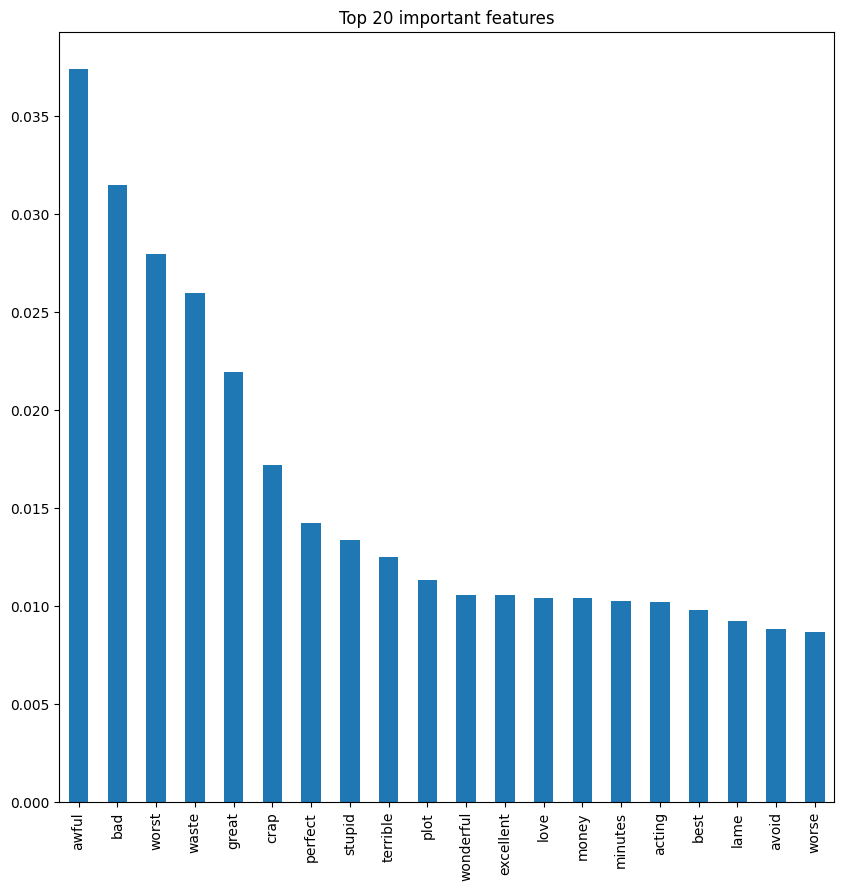

In [21]:

feat_importances = pd.Series(classifier.feature_importances_, index=vectorizer.get_feature_names_out())
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()

In [50]:
#Performance on test set 


'''
Test set  evaluation
'''

# Evaluation classifier
X_test_features = vectorizer.transform(X_test)
y_predict = classifier.predict(X_test_features)
print(f'Predictions: {y_predict}')


report = classification_report(y_test, y_predict)
print(f'Classification report: \n{report}')

report = classification_report(y_test, y_predict, output_dict=True)
print(f'Classification report: \n{report}')


Predictions: [1 1 1 ... 0 0 0]
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.81      0.85     12500
           1       0.83      0.91      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Classification report: 
{'0': {'precision': 0.8978670678821135, 'recall': 0.8116, 'f1-score': 0.8525568301189126, 'support': 12500}, '1': {'precision': 0.8281147361506459, 'recall': 0.90768, 'f1-score': 0.8660738139765658, 'support': 12500}, 'accuracy': 0.85964, 'macro avg': {'precision': 0.8629909020163797, 'recall': 0.85964, 'f1-score': 0.8593153220477392, 'support': 25000}, 'weighted avg': {'precision': 0.8629909020163797, 'recall': 0.85964, 'f1-score': 0.8593153220477392, 'support': 25000}}


### Tuning Model Hyperparameters

In [51]:
'''
Model tuning
'''

# Experimentation is needed to determine the best model configuration.
# Models with different configurations should be trained on the training set and evaluated on the validation set.
# Once the best-performing configuration is identified, this best model may be applied to the test set to determine the final performance.

# Below is a summary of possible parameters from the above example that could be tuned:
# TF-IDF
#    minimum document frequency
#    n-gram order
# RandomForestClassifier
#    number of estimators
#    maximum depth (very important)
#    class weighting

# sklearn house tools to assist with parameter tuning, like grid search: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


'''
We use a validation set for hypterparameter tuning because simply relying on the training set leads to a well known
supervised learning problem - overfitting. The model learns the training set very well but is not suitable for new
data. 

We'll be using K-fold cross validation. This can be automatically implemented in Scikit-Learn. 

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample 
from the grid, performing K-Fold CV with each combination of values.
'''

# A list of all possible RandomFoestClassifier hyperparameters that can be tuned.
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

''' 
As a starter, we can begin by tuning 2 parameters: 
    1. n_estimators: Number of trees in the random forest 
    2. max_depth: maximum levels in the tree
'''

#Setting a range of values that the hyperparameters can take
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 800, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None) #leaving maximum depth unconstrained

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

#printing the grid of parameter values
print('\n Random Grid \n')
pprint(random_grid)



# Use the random grid to search for best hyperparameters
# First create the base model to tune
classifier = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
print(f'Training started...')
rf_random.fit(X=X_valid_features, y=y_valid)
print(f'Traininig complete')

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

 Random Grid 

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'n_estimators': [50, 133, 216, 300, 383, 466, 550, 633, 716, 800]}
Training started...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Traininig complete


In [52]:
#best model parameters
print('Best Model Parameters: \n')
pprint(rf_random.best_params_)

Best Model Parameters: 

{'max_depth': 50, 'n_estimators': 633}
[CV] END .....................max_depth=50, n_estimators=633; total time=  11.0s
[CV] END .....................max_depth=70, n_estimators=383; total time=   7.5s
[CV] END .....................max_depth=10, n_estimators=383; total time=   2.0s
[CV] END .....................max_depth=60, n_estimators=466; total time=   8.7s
[CV] END .....................max_depth=30, n_estimators=550; total time=   7.0s
[CV] END ......................max_depth=50, n_estimators=50; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=383; total time=   1.9s
[CV] END .....................max_depth=10, n_estimators=383; total time=   1.9s
[CV] END .....................max_depth=60, n_estimators=466; total time=   8.6s
[CV] END .....................max_depth=80, n_estimators=300; total time=   6.1s
[CV] END .....................max_depth=50, n_estimators=383; total time=   6.7s
[CV] END .....................max_depth=30, n

In [53]:
#Re-training the RF model with tuned parameters obtained through RandomizedSearchCV

# Instantiate classifier
classifier = RandomForestClassifier( \
                                    n_estimators = 633,
                                    max_depth = 50, 
                                    class_weight = 'balanced'
                                    )
print(f'Classifier: {classifier}')


# Train (fit) classifier to training data
print(f'Training started...')
classifier.fit(X=X_train_features, y=y_train)
print(f'Traininig complete')

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=633)
Training started...
Traininig complete


In [56]:
#Performance of tuned model on test set 


'''
Test set  evaluation
'''

# Evaluation classifier
X_test_features = vectorizer.transform(X_test)
y_predict = classifier.predict(X_test_features)
print(f'Predictions: {y_predict}')


report = classification_report(y_test, y_predict)
print(f'Classification report: \n{report}')

report = classification_report(y_test, y_predict, output_dict=True)
print('Classification report: \n')
pprint(report)


Predictions: [1 1 1 ... 0 0 0]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12500
           1       0.96      0.97      0.96     12500

    accuracy                           0.96     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000

Classification report: 

{'0': {'f1-score': 0.962014098690836,
       'precision': 0.968843813387424,
       'recall': 0.95528,
       'support': 12500},
 '1': {'f1-score': 0.9625422045680239,
       'precision': 0.9558974358974359,
       'recall': 0.96928,
       'support': 12500},
 'accuracy': 0.96228,
 'macro avg': {'f1-score': 0.9622781516294299,
               'precision': 0.96237062464243,
               'recall': 0.96228,
               'support': 25000},
 'weighted avg': {'f1-score': 0.9622781516294299,
                  'precision': 0.9623706246424301,
                  'recall': 0.96228,
            

In [57]:
'''
After tuning parameters, we are able to obtain a 10% lift in accuracy on the test set. 

'''

'\nAfter tuning parameters, we are able to obtain a 10% lift in accuracy on the test set. \n\n'

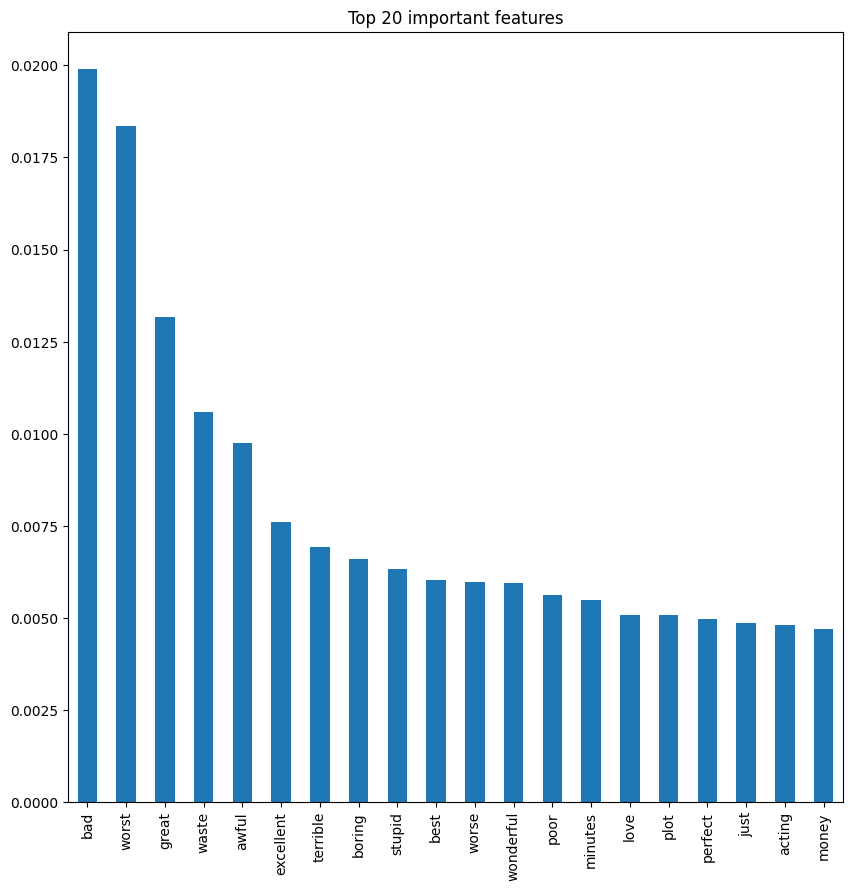

In [58]:

feat_importances = pd.Series(classifier.feature_importances_, index=vectorizer.get_feature_names_out())
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()


#There is a slight change in the features that are important in the model. 

In [ ]:
'''
Model architectures
'''

# sklearn has many different classification architectures that could be relatively easily integrated into this pipeline.
# Below are a few examples:
# Logistic regression/maximum entropy – https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Support Vector Machines - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Multilayer perceptron (neural network) - https://scikit-lean.org/stable/modules/neural_networks_supervised.html

# Each of these architectures and implementations through sklearn will have different parameters that must be selected/tuned.

In [59]:
#As an example, we can implement a logistic regression model as well. 

In [105]:
# define logistic regression model
estimator = LogisticRegression(
    random_state = 1,
    penalty = 'l2', 
    C = 0.01
)
estimator.fit(X=X_train_features, y=y_train)

LogisticRegression(C=0.01, random_state=1)

In [106]:
#Performance of base model on test set 

'''
Test set  evaluation on base logistic regression model
'''

# Evaluation classifier
y_predict = estimator.predict(X_test_features)
print(f'Predictions: {y_predict}')


report = classification_report(y_test, y_predict)
print(f'Classification report: \n{report}')

Predictions: [1 1 1 ... 0 0 1]
Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.77      0.80     12500
           1       0.79      0.85      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [107]:
#Defining the random grid for RandomizedSearchCV

'''
The following parameters will be tuned: 
penalty - L1, L2
C - Inverse of regularization strength [smaller values represent stronger regularization]

There is only one solver in the parameters, therefore it is not being tuned
'''


#Defining ranges and possible values 
max_iter = range(100, 500)
solver = ['liblinear'] #liblinear supports both L1 and L2 regularization, other engines are selective
penalty = ['l1', 'l2']
C = np.arange(0.01, 1, 0.01)

#defining the grid
random_grid ={
    'max_iter' : max_iter,
    'penalty' : penalty,
    'solver' : solver,
    'C' : C,
}

#tuning hyperparameters to find best parameters 

random_estimator = RandomizedSearchCV(estimator = estimator,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )
#fitting on validation set
random_estimator.fit(X=X_valid_features, y=y_valid)


#best hyperparameters obtained through RandomizedSearchCV

print('\n Best HyperParameters: \n')
random_estimator.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Best HyperParameters: 



{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 201,
 'C': 0.8400000000000001}

In [103]:
#re-fitting model with tuned hyperparameters


# define logistic regression model
estimator = LogisticRegression(
    random_state = 1,
    solver= 'liblinear',
    penalty = 'l2', 
    C = 0.840,
    max_iter = 201 
)
estimator.fit(X=X_train_features, y=y_train)

LogisticRegression(C=0.84, max_iter=201, random_state=1, solver='liblinear')

In [104]:
#Performance of tuned model on test set 

'''
Test set  evaluation on logistic regression model with tuned hyperparameters
'''

# Evaluation classifier
y_predict = estimator.predict(X_test_features)
print(f'Predictions: {y_predict}')


report = classification_report(y_test, y_predict)
print(f'Classification report: \n{report}')

Predictions: [1 1 1 ... 0 0 0]
Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     12500
           1       0.91      0.93      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



In [ ]:
'''
We have obtained an 11% lift through hyperparameter tuning in the logistic regression model. 
'''
